# Multi-period (Lifecycle) model

### Setup
There is a unit mass of households. They enter the economy at age 20 ($j=1$) without asset, supply one unit of labor exogenously until age 65 ($j=J_R=46$), which gives them $w$ unit of income, and they die at age 80 $(j=J=61)$. They derive utility from consumption ($c_j$) every period, and they discount future by $\beta$. The asset ($a_j$) earns an interest with rate $r$. They are not allowed to borrow (i.e., $a_{j+1}\ge 0$). The problem reads as follows:

\begin{align*}
    & \max_{\{c_j\}_{j=1}^J} \sum_{j=1}^J \beta^{j-1} u(c_j)\\
    \text{s.t.} & \\
    c_j &= 
    \begin{cases}
        w + (1+r)a_j - a_{j+1} & \text{if}~~~j\le J_R\\
        (1+r)a_j - a_{j+1} & \text{if}~~~j\in\{J_R+1,...,J-1\}\\
        (1+r)a_j & \text{if}~~~j=J\\
    \end{cases}\\
    & a_1=0, ~~a_{j+1} \ge 0~~~\forall j
\end{align*}

If we want to solve it analytically, we have to solve $J-1(=60)$ equations (first-order conditions):
$$
u'(c_j) = (1+r)\beta u'(c_{j+1})~~~\forall j=1,...,J-1
$$

How do we solve the problem computationally? We solve it $\textit{backward}$, given that we know that at the end of their life, they consume everything (i.e., $c_J=(1+r)a_{J}$). 

Recursive formulation is useful for understanding and implementing this computational algorithm. Here, the state variables are age $j$ and current asset holdings $a$, with $a'$ representing next period's asset holdings. The value function is given as follows:

\begin{align*}
    V(a,j) = & \max_{a'\ge 0} u(c) + \beta \left\{
    \begin{array}{rr}
    V(a',j+1) & \text{if} \ j < J\\
    0         & \text{if} \ j = J
    \end{array}
    \right. \\
    \text{s.t.} & \\
    c &= 
    \begin{cases}
        w + (1+r)a - a' & \text{if}~~~j\le J_R\\
        (1+r)a - a' & \text{if}~~~j\in\{J_R,...,J-1\}\\
        (1+r)a & \text{if}~~~j=J\\
    \end{cases}
\end{align*}

We know that, at the end of life (i.e., age $j=J$), the value function is given as:

$$
V(a,J) = u((1+r)a)
$$

Given the value function at the final period, the value function at age $J-1$ is given by:

$$
V(a,J-1) = \max_{a'\ge0} \left\{u((1+r)a - a') + \beta V(a',J)\right\}
$$

We can solve this problem by, for example, grid search method: given $a\in\mathcal{A}$, where $\mathcal{A}$ is the discretized asset space, we search for the optimal $a'$ that solves this value function. Once we obtain the value function $V(a,J-1)$, we can proceed similarly for age $J-2$, and so on. This procedure—solving the problem recursively from the final period backward—is known as $\textit{backward induction}$.

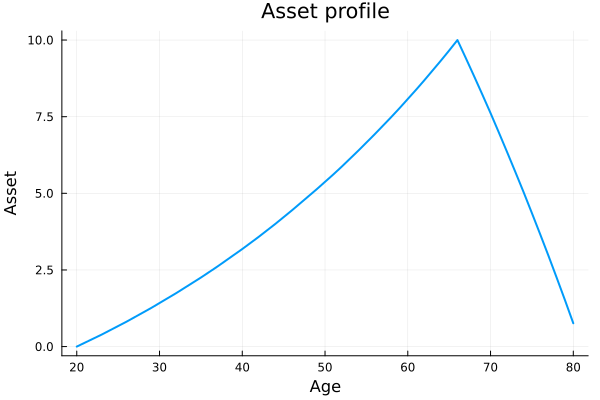

In [17]:
using Plots

# parameters
β=0.98
r=0.02
w=1.0

# discretization for asset space
mina = 1.e-5 # lower bound (close to zero but not exactly (to avoid c=0))
maxa = 10.0  # upper bound
na   = 1000  # number of grid
grida = collect(LinRange(mina,maxa,na)); # construct discretized asset space

# age related parameters
J=61  # length of lifecycle
JR=46 # timing of retirement

# value function and policy functions
V = zeros(na,J); # value function V(a,j)
Va = zeros(na);  # vector for grid search
apol = zeros(na,J); # policy function for saving (value) a(a,J)
apol_arg = zeros(Int,na,J); # policy function for saving (index over asset space, grida)
cpol = zeros(na,J)  # policy function for consumption c(a,J)

penalty=-1.e+8

for jc in J:-1:1 # solve backward
    for ac in 1:na
        if (jc==J) # compute final consumption given a
            c = (1.0+r)*grida[ac]
            if (c>0)
                V[ac,jc]=log(c)
            else # "punish" c<=0
                V[ac,jc]=penalty
            end
            cpol[ac,jc]=c; # store it in policy function for c
        elseif (JR < jc) && (jc < J) # retirement period (except for the final period)
            Va.=penalty;
            for acc in 1:na
                c = (1.0+r)*grida[ac]-grida[acc]
                if (c>0)
                    Va[acc] = log(c) + β*V[acc,jc+1]
                else
                    Va[acc] = penalty
                end
            end
            arg = argmax(Va)
            apol_arg[ac,jc]=arg
            apol[ac,jc] = grida[arg]
            V[ac,jc] = Va[arg]
            cpol[ac,jc]=(1.0+r)*grida[ac]-grida[arg];
        else
            Va.=penalty;
            for acc in 1:na
                c = w+(1.0+r)*grida[ac]-grida[acc]
                if (c>0)
                    Va[acc] = log(c) + β*V[acc,jc+1]
                else
                    Va[acc] = penalty
                end
            end
            arg = argmax(Va)
            acc_start = arg
            apol_arg[ac,jc]=arg
            apol[ac,jc] = grida[arg]
            V[ac,jc] = Va[arg]
            cpol[ac,jc]=w + (1.0+r)*grida[ac]-grida[arg];
        end
    end
end

# find asset profile aj
aj = zeros(J);
aj[1]=grida[1]; # start from no-asset
a_arg = ones(Int,J);
arg_yesterday=1;
for jc in 2:J
    arg_yesterday=a_arg[jc-1];
    arg = apol_arg[arg_yesterday,jc-1];
    aj[jc]=grida[arg];
    a_arg[jc]=arg;
end

# find consumption
cj = zeros(J);
for jc in 1:J
    arg = a_arg[jc];
    cj[jc]=cpol[arg,jc]
end

## plot asset profile
plot(20:20+J-1, aj,
    xlabel="Age",
    ylabel="Asset",
    title="Asset profile",
    lw=2,
    label="")

## Exercise
1. Construct a function that solves the model, taking key (deep) parameters as inputs.
2. Solve the model and plot the results for different values of parameters (e..g, compare asset profile under $\beta=0.98$ vs. $\beta=0.90$).
3. The following code runs faster than the one above, given the same number of grid points na (For example, try comparing the execution time with na=1000). Think about why the version below runs faster (hint: the key factors are the use "v0" and "acc_start").

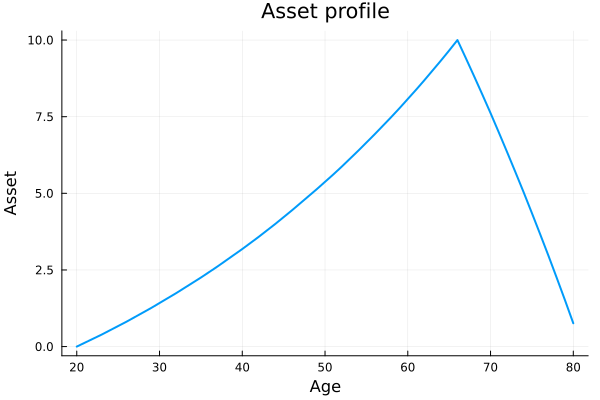

In [18]:
using Plots

# parameters
β=0.98
r=0.02
w=1.0

# discretization for asset space
mina = 1.e-5 # lower bound (close to zero but not exactly (to avoid c=0))
maxa = 10.0  # upper bound
na   = 1000  # number of grid
grida = collect(LinRange(mina,maxa,na)); # construct discretized asset space

# age related parameters
J=61  # length of lifecycle
JR=46 # timing of retirement

# value function and policy functions
V = zeros(na,J); # value function V(a,j)
Va = zeros(na);  # vector for grid search
apol = zeros(na,J); # policy function for saving (value) a(a,J)
apol_arg = zeros(Int,na,J); # policy function for saving (index over asset space, grida)
cpol = zeros(na,J)  # policy function for consumption c(a,J)

penalty=-1.e+8

for jc in J:-1:1 # solve backward
    acc_start=1 # for speed up
    for ac in 1:na
        if (jc==J) # compute final consumption given a
            c = (1.0+r)*grida[ac]
            if (c>0)
                V[ac,jc]=log(c)
            else # "punish" c<=0
                V[ac,jc]=penalty
            end
            cpol[ac,jc]=c; # store it in policy function for c
        elseif (JR < jc) && (jc < J) # retirement period (except for the final period)
            Va.=penalty;
            v0=penalty
            for acc in acc_start:na
                c = (1.0+r)*grida[ac]-grida[acc]
                if (c>0)
                    Va[acc] = log(c) + β*V[acc,jc+1]
                else
                    Va[acc] = penalty
                end

                if (Va[acc]>v0)
                    v0=Va[acc]
                    acc_start=acc
                else
                    break
                end
            end
            arg = acc_start
            apol_arg[ac,jc]=arg
            apol[ac,jc] = grida[arg]
            V[ac,jc] = Va[arg]
            cpol[ac,jc]=(1.0+r)*grida[ac]-grida[arg];
        else
            Va.=penalty;
            v0=penalty
            for acc in acc_start:na
                c = w+(1.0+r)*grida[ac]-grida[acc]
                if (c>0)
                    Va[acc] = log(c) + β*V[acc,jc+1]
                else
                    Va[acc] = penalty
                end

                if (Va[acc]>v0)
                    v0=Va[acc]
                    acc_start=acc
                else
                    break
                end

            end
            arg = acc_start
            acc_start = arg
            apol_arg[ac,jc]=arg
            apol[ac,jc] = grida[arg]
            V[ac,jc] = Va[arg]
            cpol[ac,jc]=w + (1.0+r)*grida[ac]-grida[arg];
        end
    end
end

# find asset profile aj
aj = zeros(J);
aj[1]=grida[1]; # start from no-asset
a_arg = ones(Int,J);
arg_yesterday=1;
for jc in 2:J
    arg_yesterday=a_arg[jc-1];
    arg = apol_arg[arg_yesterday,jc-1];
    aj[jc]=grida[arg];
    a_arg[jc]=arg;
end

# find consumption
cj = zeros(J);
for jc in 1:J
    arg = a_arg[jc];
    cj[jc]=cpol[arg,jc]
end

## plot asset profile
plot(20:20+J-1, aj,
    xlabel="Age",
    ylabel="Asset",
    title="Asset profile",
    lw=2,
    label="")